# Brazilian Stocks Return and Analyis
The data used in this demo comes from Google Sheets.
From there you get use the native function =GOOGLEFINANCE(symbol, start_period, end_period) to fetch the raw data for the BRZ assets. 

Below I show you how :
* to clean and structure the data in a time series that can be used to perform analysis regarding the price evolution of a stock
* the relative and absolute return
* simulate how buch would we withdrawn if we have invested 'x' BRL since a certain start_date.

In [1]:
import os
import random
import matplotlib
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

In [2]:
ibx = pd.read_csv('./csv/raw_ibx_google_sheets.csv')
ibx.head()

/home/gaston/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,1,2,3,4,5,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,59,60,61,62,63,64,65,66,67,69,71,72,73,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivi

,ABEV3,Unnamed: 1,AZUL4,Unnamed: 3,B3SA3,Unnamed: 5,BBAS3,Unnamed: 7,BBDC3,Unnamed: 9,...,MATB11,Unnamed: 225,ISUS11,Unnamed: 227,PIBB11,Unnamed: 229,SMAC11,Unnamed: 231,SPXI11,Unnamed: 233
0,Date,Close,Date,Close,Date,Close,Date,Close,Date,Close,...,Date,Close,Date,Close,Date,Close,Date,Close,Date,Close
1,11/11/2013 16:56:00,17.4,4/11/2017 16:56:00,22.4,8/20/2008 16:56:00,11.84,1/2/2002 16:56:00,3.59,1/2/2002 16:56:00,2.29,...,2/1/2012 16:56:00,18.64,11/3/2011 16:56:00,19.9,5/9/2006 16:56:00,60.45,2/3/2020 16:56:00,72.8,5/9/2016 16:56:00,73.55
2,11/12/2013 16:56:00,17.06,4/12/2017 16:56:00,22.96,8/21/2008 16:56:00,11.47,1/3/2002 16:56:00,3.65,1/3/2002 16:56:00,2.31,...,2/3/2012 16:56:00,19.07,12/20/2011 16:56:00,19.51,5/10/2006 16:56:00,60.4,2/4/2020 16:56:00,73.7,5/10/2016 16:56:00,73.28
3,11/13/2013 16:56:00,17.03,4/13/2017 16:56:00,22.99,8/22/2008 16:56:00,11.48,1/4/2002 16:56:00,3.57,1/4/2002 16:56:00,2.3,...,2/6/2012 16:56:00,18.98,12/22/2011 16:56:00,19.99,5/11/2006 16:56:00,60,2/5/2020 16:56:00,74.1,5/11/2016 16:56:00,72.28
4,11/14/2013 16:56:00,17.47,4/17/2017 16:56:00,22.85,8/25/2008 16:56:00,11.21,1/7/2002 16:56:00,3.49,1/7/2002 16:56:00,2.31,...,2/8/2012 16:56:00,19.09,1/5/2012 16:56:00,20.34,5/12/2006 16:56:00,59,2/6/2020 16:56:00,72.72,5/12/2016 16:56:00,72.94


## Main Functions
Below functions help us to give form to the unified time series and also to plot the data in a way that would help us to conduct the analysis.

In [3]:
def clean_google_finance_raw_data(ibx):
    '''
    Takes raw data from google finance and structure it in a big time series where each column 
    corresponds to a Brazilian stock and each line their close price
    '''
    cols = len(ibx.columns)     # get total number of columns, should always be an even number, 1st a date, 2nd the close prices
    stocks = []
    for i in range(0, cols, 2):
        _ = ibx.iloc[ : , i : i+2].dropna() # slices the main dataframe by data / prices of each sybol and remove any na values
        _ = _.iloc[1:]                      # remove first row, with 2nd level of columns labels
        ticker = _.columns[0]               # gets the symbol name
        _.columns = ['date', ticker]        # rename teh dataframe columns
        _['date'] = pd.to_datetime(pd.to_datetime(_['date']).dt.date) # truncates timestamp from the date column, converted to datetime
        _.set_index('date', inplace=True)   # set date as index, to create a time series
        stocks.append(_)                    # add the cleaned framte to a master list
    return pd.concat(stocks, axis=1).sort_index().ffill().bfill().apply(pd.to_numeric, errors='coerce') # concatenates all dataframes from all symbols by column


def get_stocks_relative_return(df, symbols=[], start='2008', end=None, style='ggplot'):
    '''
    Given a dataframe and a list of stocks a a start date, the function plots 
    the stock performance agaist the price at the start date.
    '''
    period = slice(start, end)
    _ = df[period]
    if symbols != []:
        _ = _[symbols]
        _norm = _.div(_.iloc[0]).mul(100) # divide all the seires for the first value to get the relative increase or decrease
        plt.style.use(style)
        _norm.plot(figsize=(21,12), title='Return relative to the price at the initial period')
        plt.show()
    else:
        print('No Symbol specified')


def get_stocks_absolute_return(df, symbols=[], start='2008', end=None, style='ggplot'):
    '''
    Given a dataframe and a list of stocks a a start date, plots the percentage 
    return of the stock for the given period.
    '''
    period = slice(start, end)
    _ = df[period]
    if symbols != []:
        _ = _[symbols]
        stock_return = _.pct_change().add(1).cumprod().sub(1).mul(100)
        plt.style.use(style)
        stock_return.plot(figsize=(21,12), title='% Absolute Return')
        plt.show()
    else:
        print('No Symbol specified')


def get_stock_performance(df, stock, investment=1000, start='2008', end=None, style='ggplot'):
    '''
    Plots the price evolution, the volatility of the daily stock returns, the 
    cummulative percentage evolution and how much would a initial investment be valued
    since the given start date.
    '''
    period = slice(start, end)
    r = 'return_over_{:,}'.format(investment)
    _ = df[period][[stock]]
    _['pct_change'] = _.pct_change().fillna(0)
    _['stock_return'] = _['pct_change'].add(1).cumprod().sub(1).mul(100).fillna(0)
    _[r] = _['pct_change'].add(1).cumprod().mul(investment).fillna(1)
    titles = ['{} Price'.format(stock),
              '{} Daily Percentage Change'.format(stock),
              '{} Percentage Cummulative Performance'.format(stock),
              '{} Return If You Have Invested R$ {:,}'.format(stock, investment)]
    plt.style.use(style)
    i = _.plot(figsize=(21,17), subplots=True, title=titles)
    plt.show()

def get_portfolio_return(df, stocks=['IVVB11', 'SPXI11', 'SMAL11', 'PIBB11'], start='2008', end=None, style='ggplot'):
    period = slice(start, end)
    portfolio = df[period][stocks]
    #initial_prices = portfolio.iloc[0]
    ptfl = portfolio.pct_change().fillna(0)
    ptfl_t = ptfl.T 
    ptfl_t.loc['PORTFOLIO_RETURN'] = ptfl_t.mean()
    ptf = ptfl_t.T.add(1).cumprod().sub(1).mul(100)
    plt.style.use(style)
    ptf.plot(figsize=(23,12))
    plt.show()

## Aesthetic Functions
Functions to help to display and analyse the data

In [4]:
def plot_correlation(df, cmap='cool', s=7, style='ggplot'):
    '''
    Receives a dataframe df and displays a matrix showing the variables correlations.
    Arguments:
         * df   = a pandas dataframe
         * cmap = the colormap to be used (default is "cool") [optional]
         * s    = the size in inches of the figure output (default is 6) [optional]
    '''
    # create correlation dataframe and plot it
    correlations = df.corr()
    plt.style.use(style)
    fig, ax = plt.subplots(figsize=(s,s))
    ax.matshow(correlations, cmap=cmap)
    
    # add lables to x and y axis
    c = df.columns
    i = range(len(c))
    plt.xticks(i,c, rotation='vertical', fontsize=13)
    plt.yticks(i,c, fontsize=13)
    
    # add contenta annotations to each cell
    if cmap in ['cool', 'plasma', 'autumn', 'bwr', 'coolwarm']: 
        color = 'k' 
    else: 
        color = 'w'
    
    for j in i:
        for k in i:
            text = ax.text(k, j, 
                           round(correlations.iloc[j,k], 2),
                           ha='center',
                           va='center',
                           color=color)
   
    plt.show()

## EDA Analysis

In [5]:
brz = clean_google_finance_raw_data(ibx)
brz.head() # check the format of the cleaned datafram

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BIDI11,BPAC11,...,SMAL11,BOVV11,DIVO11,FIND11,GOVE11,MATB11,ISUS11,PIBB11,SMAC11,SPXI11
date,,,,,,,,,,,,,,,,,,,,,
2002-01-02,17.4,22.4,11.84,3.59,2.29,2.69,16.6,19.0,74.0,17.5,...,22.71,57.59,30.7,36.8,22.04,18.64,19.9,60.45,72.8,73.55
2002-01-03,17.4,22.4,11.84,3.65,2.31,2.69,16.6,19.0,74.0,17.5,...,22.71,57.59,30.7,36.8,22.04,18.64,19.9,60.45,72.8,73.55
2002-01-04,17.4,22.4,11.84,3.57,2.30,2.69,16.6,19.0,74.0,17.5,...,22.71,57.59,30.7,36.8,22.04,18.64,19.9,60.45,72.8,73.55
2002-01-07,17.4,22.4,11.84,3.49,2.31,2.69,16.6,19.0,74.0,17.5,...,22.71,57.59,30.7,36.8,22.04,18.64,19.9,60.45,72.8,73.55
2002-01-08,17.4,22.4,11.84,3.47,2.31,2.69,16.6,19.0,74.0,17.5,...,22.71,57.59,30.7,36.8,22.04,18.64,19.9,60.45,72.8,73.55


In [6]:
# validates basic info of the dataframe
brz.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2002-01-02 to 2020-04-17
Columns: 117 entries, ABEV3 to SPXI11
dtypes: float64(117)
memory usage: 3.9 MB


In [7]:
# get the basic statistics of each column
brz.describe()

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BIDI11,BPAC11,...,SMAL11,BOVV11,DIVO11,FIND11,GOVE11,MATB11,ISUS11,PIBB11,SMAC11,SPXI11
count,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,...,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000,4368.000000
mean,17.707720,24.504748,15.135868,24.827908,12.904441,12.415041,21.283242,11.931777,72.887234,20.230563,...,49.911280,62.776177,33.714265,49.288986,24.563533,19.647230,22.827665,89.494895,72.596291,79.407074
std,1.234505,6.611602,8.273613,14.281314,7.420581,8.619041,6.376862,5.362349,5.773697,9.976186,...,26.434941,12.687869,8.162506,22.847493,6.327402,5.273361,4.435844,31.903944,2.366364,15.479617
min,11.030000,10.350000,4.010000,2.670000,1.460000,1.880000,16.600000,1.550000,24.510000,12.600000,...,22.400000,57.140000,17.290000,28.000000,16.000000,10.700000,18.580000,43.700000,36.980000,67.920000
25%,17.400000,22.400000,11.840000,14.470000,8.230000,2.690000,16.600000,7.600000,74.000000,17.500000,...,22.710000,57.590000,30.700000,36.800000,22.040000,18.380000,19.900000,60.450000,72.800000,73.550000
50%,17.400000,22.400000,11.840000,24.595000,12.280000,12.660000,16.600000,10.810000,74.000000,17.500000,...,51.710000,57.590000,30.700000,36.800000,22.040000,18.640000,19.900000,85.490000,72.800000,73.550000
75%,17.400000,22.400000,13.975000,30.300000,17.360000,17.175000,27.600000,19.000000,74.000000,17.500000,...,67.020000,57.590000,33.850000,51.552500,22.040000,18.640000,24.532500,96.820000,72.800000,73.550000
max,24.270000,62.410000,53.130000,83.290000,34.670000,35.830000,38.320000,20.500000,75.700000,81.450000,...,146.700000,120.030000,71.500000,131.400000,52.110000,40.500000,43.790000,201.220000,74.100000,158.380000


In [8]:
# filters the etf symbols and sets a global initial date
ETFs = brz.columns[-17:].tolist()
ini = '2019'

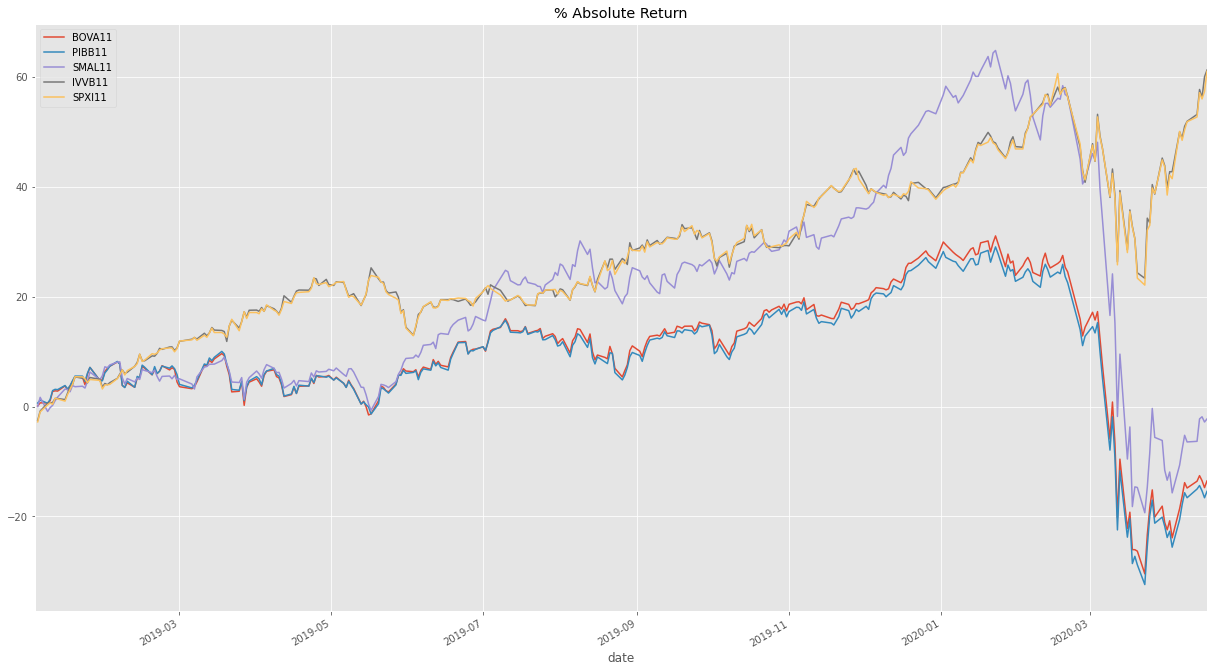

In [9]:
get_stocks_absolute_return(brz, symbols=['BOVA11', 'PIBB11', 'SMAL11', 'IVVB11', 'SPXI11'], start=ini)

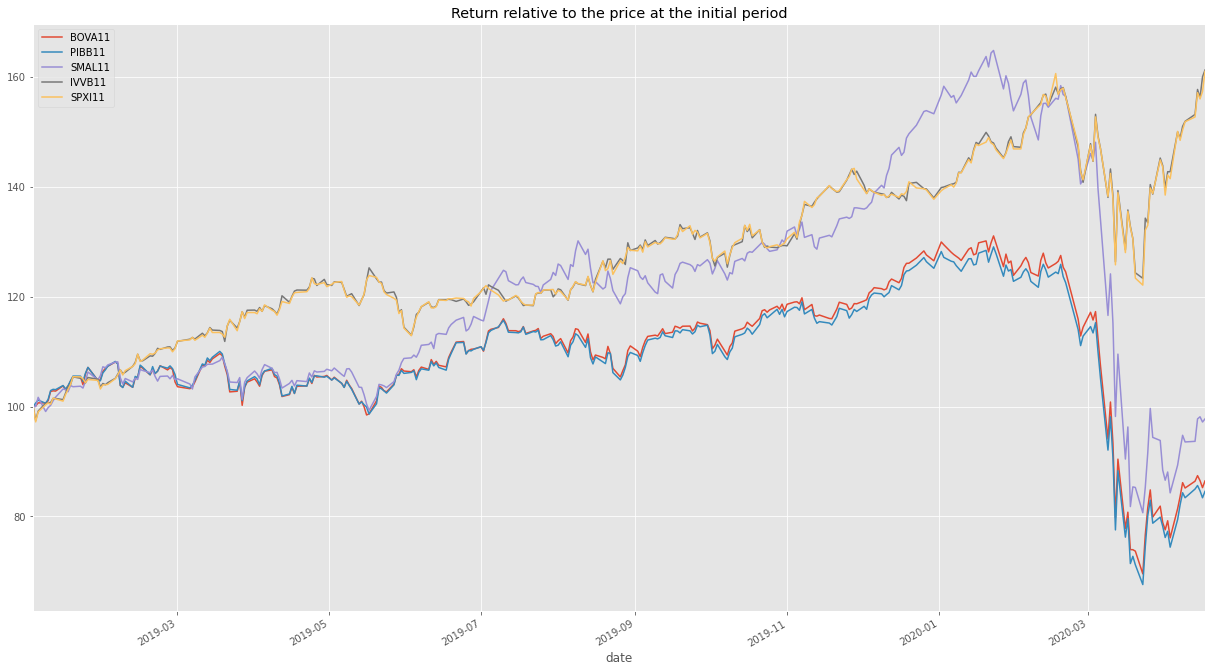

In [10]:
get_stocks_relative_return(brz, symbols=['BOVA11', 'PIBB11', 'SMAL11', 'IVVB11', 'SPXI11'], start=ini)

/home/gaston/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/gaston/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/gaston/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home/gaston/.local/lib/python3.7/site-packages/pa

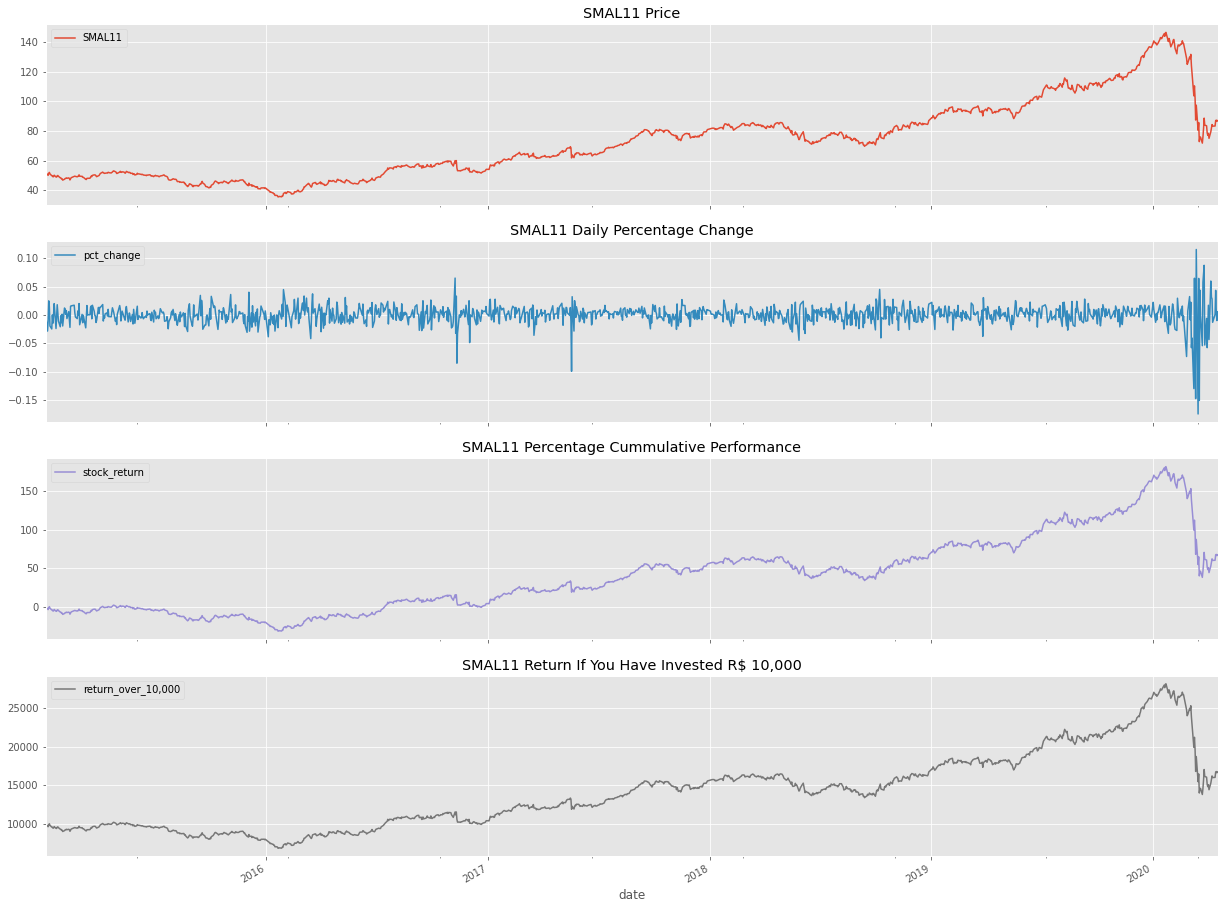

In [11]:
get_stock_performance(brz, 'SMAL11', 10000, '2015')

In [12]:
# selects the daily % change of the etfs since 2015
etfs_df = brz['2015':][ETFs].pct_change().dropna()

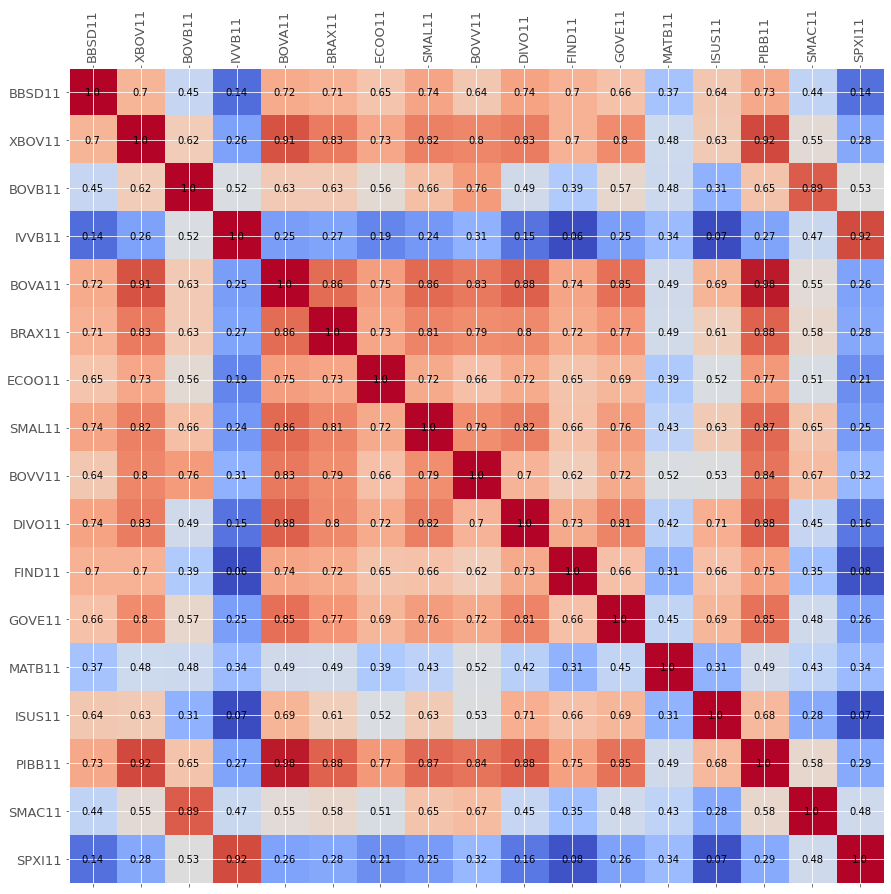

In [13]:
# validates the correlation of the returns
plot_correlation(etfs_df, cmap='coolwarm', s=15)

## Getting average return of a simple portfolio
With the above correlational plot we can see a strong correlation between:
* IVVB11 and SPXI11
* PIBB11 and SMAL11
Also we can see a weak correlation between:
* IVVB11, SPXI11 against PIBB11, SMAL11

This may happen because IVVB11 and SPXI11 try to track the S&P500 index, although PIBB11 tracks the IBOV index and SMAL11 tracks the Brazil Small Caps index.

Knowing so, a good balanced strategy could be mixing these two asset classes in a same portfolio, in order to provide a general balance that goes well when the Brazil domestic market performns better (PIBB11 and SMAL11) and case it performs bad, the other half will track the US market (IVVB11 and SPXI11).

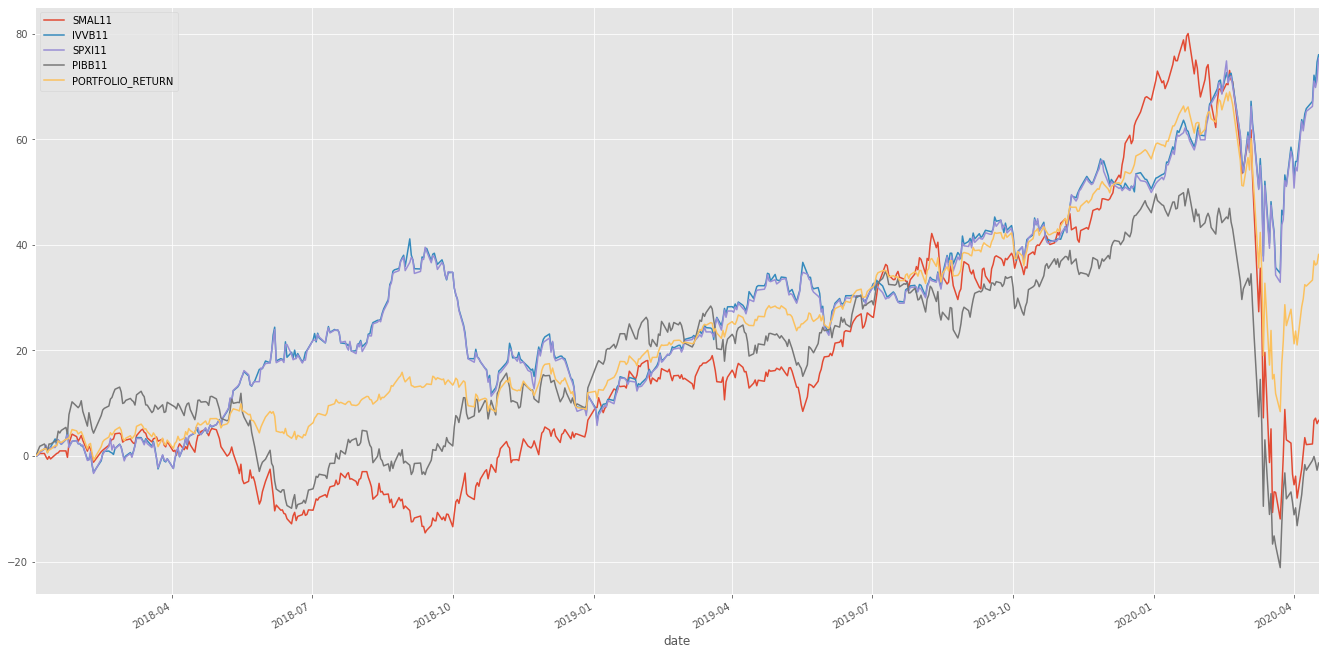

In [14]:
get_portfolio_return(brz, stocks=['SMAL11', 'IVVB11', 'SPXI11', 'PIBB11'], start='2018')

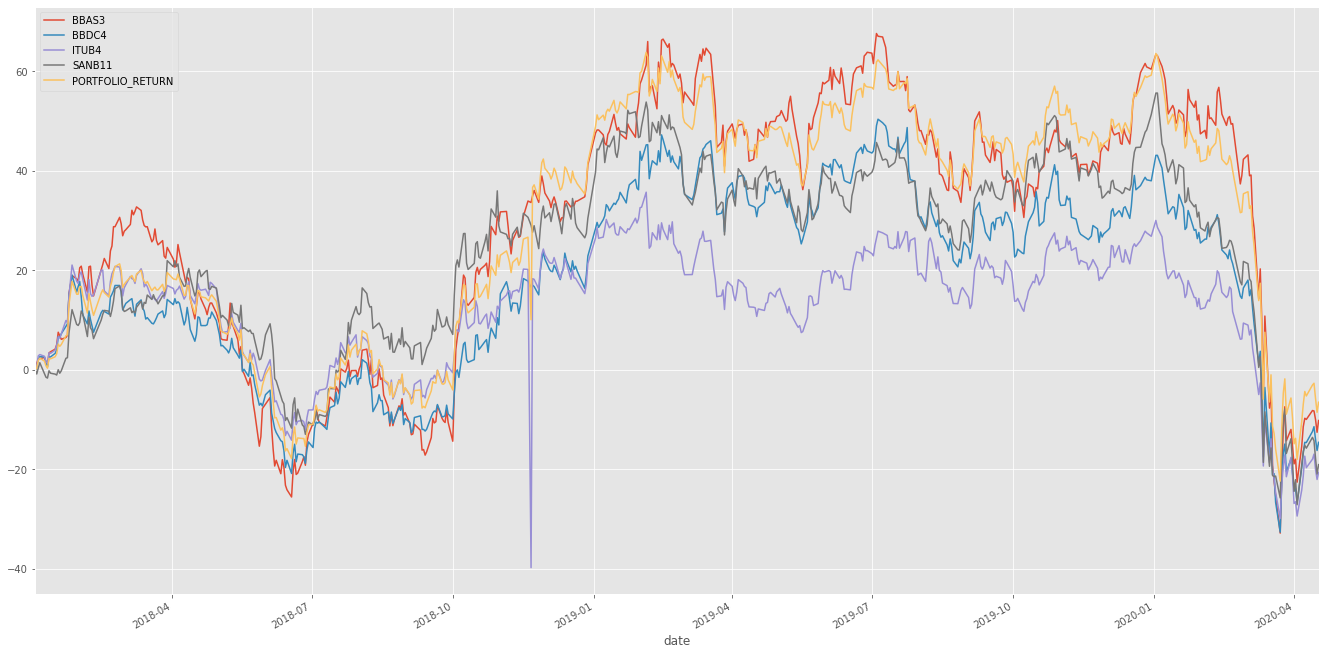

In [15]:
get_portfolio_return(brz, stocks=['BBAS3', 'BBDC4', 'ITUB4', 'SANB11'], start='2018')

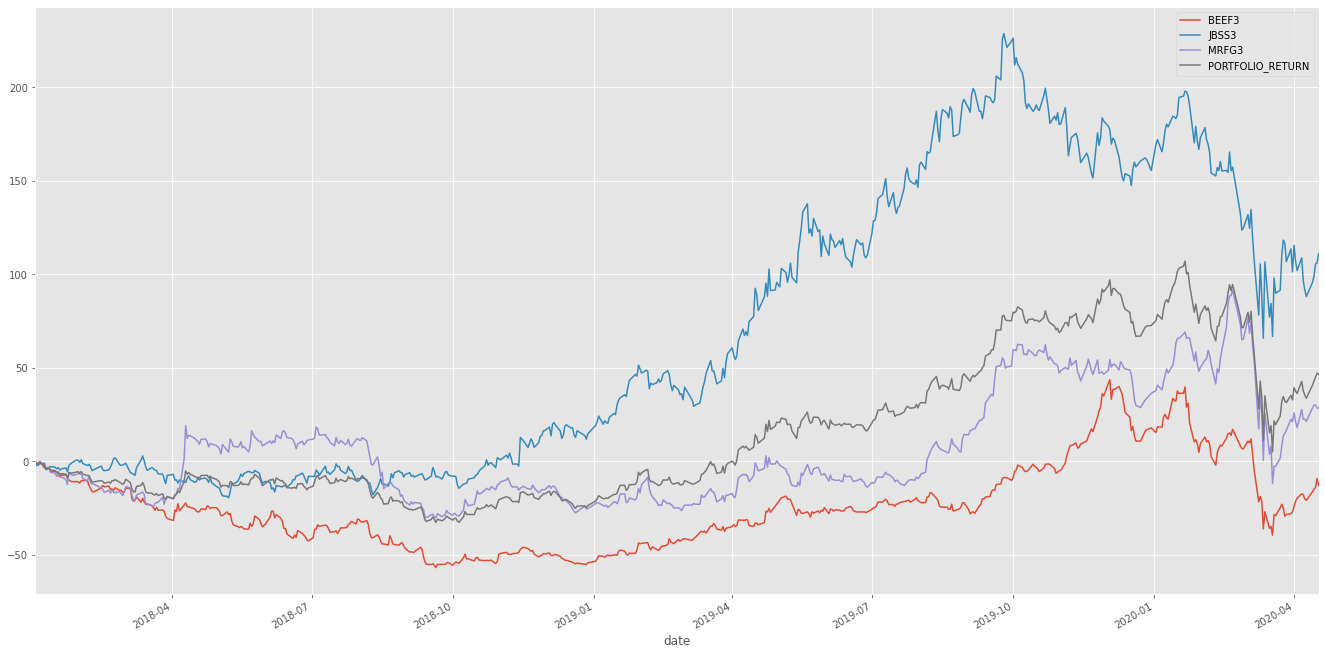

In [16]:
get_portfolio_return(brz, stocks=['BEEF3', 'JBSS3', 'MRFG3'], start='2018')

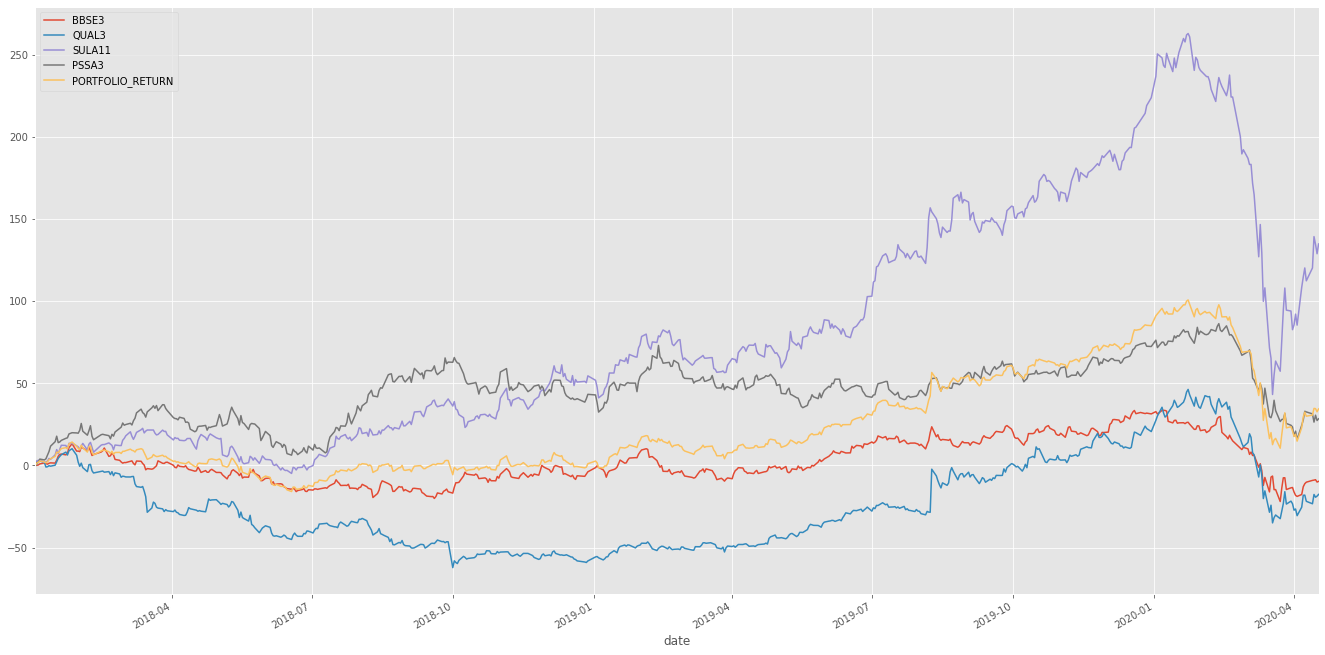

In [17]:
get_portfolio_return(brz, stocks=['BBSE3', 'QUAL3', 'SULA11', 'PSSA3'], start='2018')

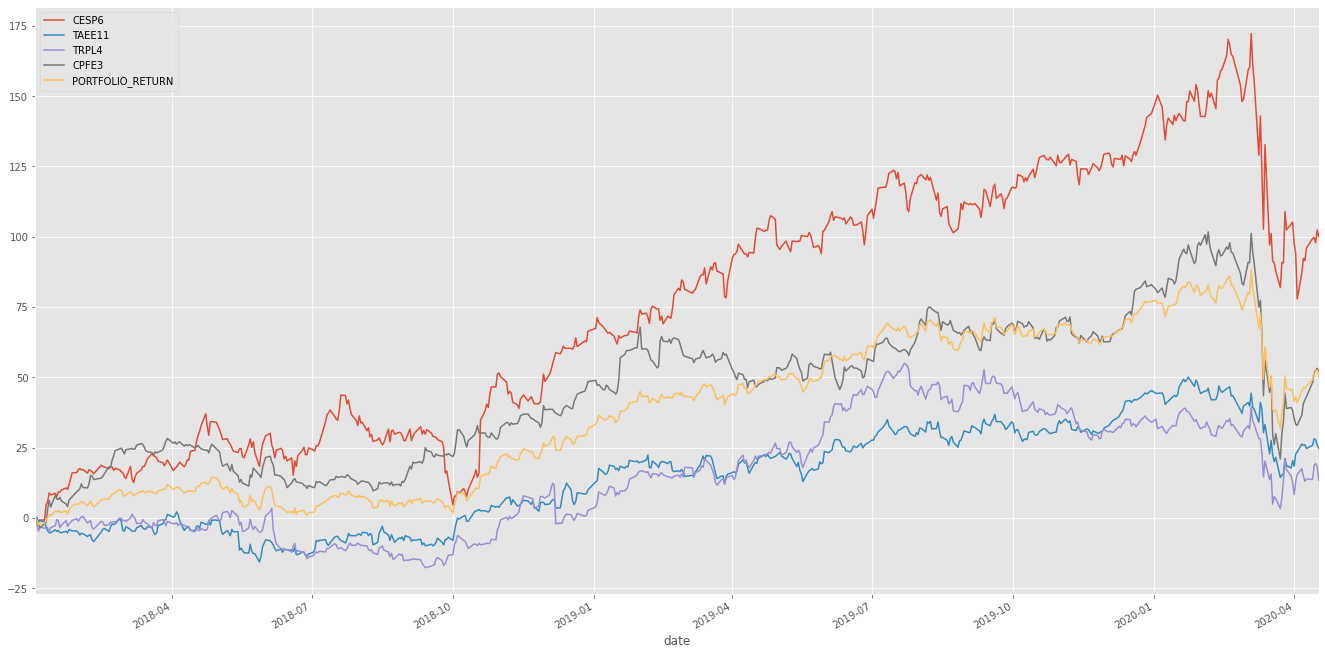

In [18]:
get_portfolio_return(brz, stocks=['CESP6', 'TAEE11', 'TRPL4', 'CPFE3'], start='2018')

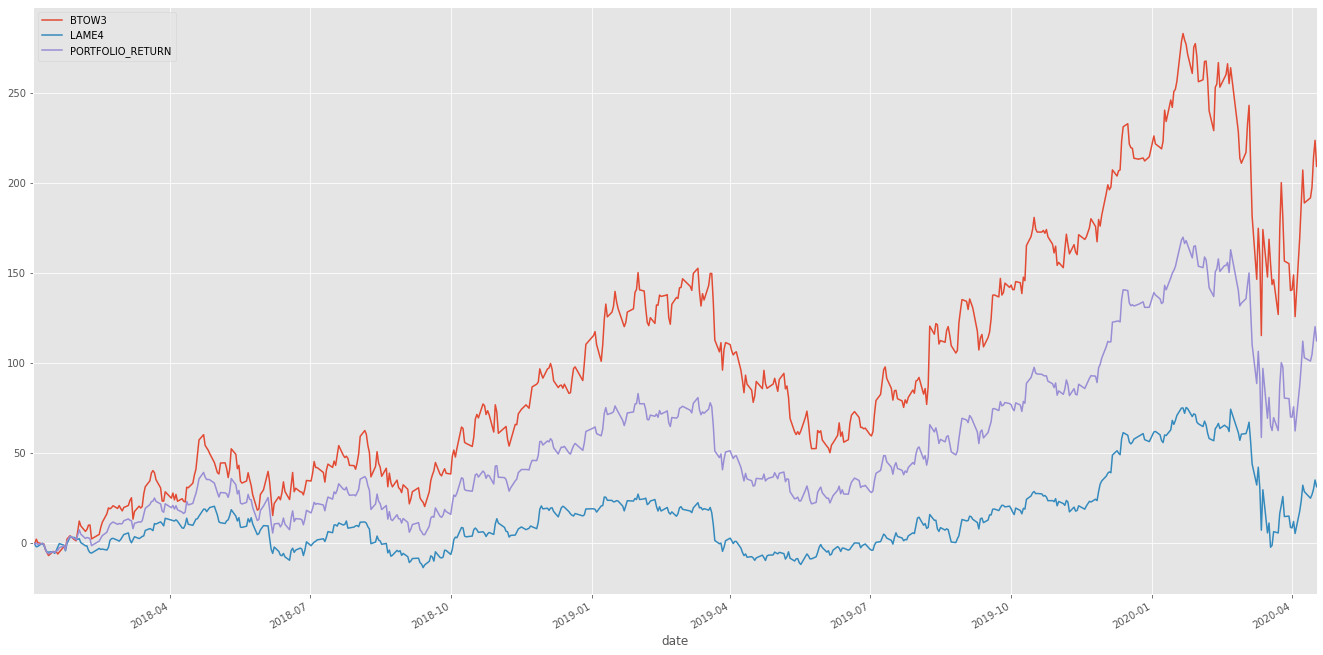

In [19]:
get_portfolio_return(brz, stocks=['BTOW3', 'LAME4'], start='2018')

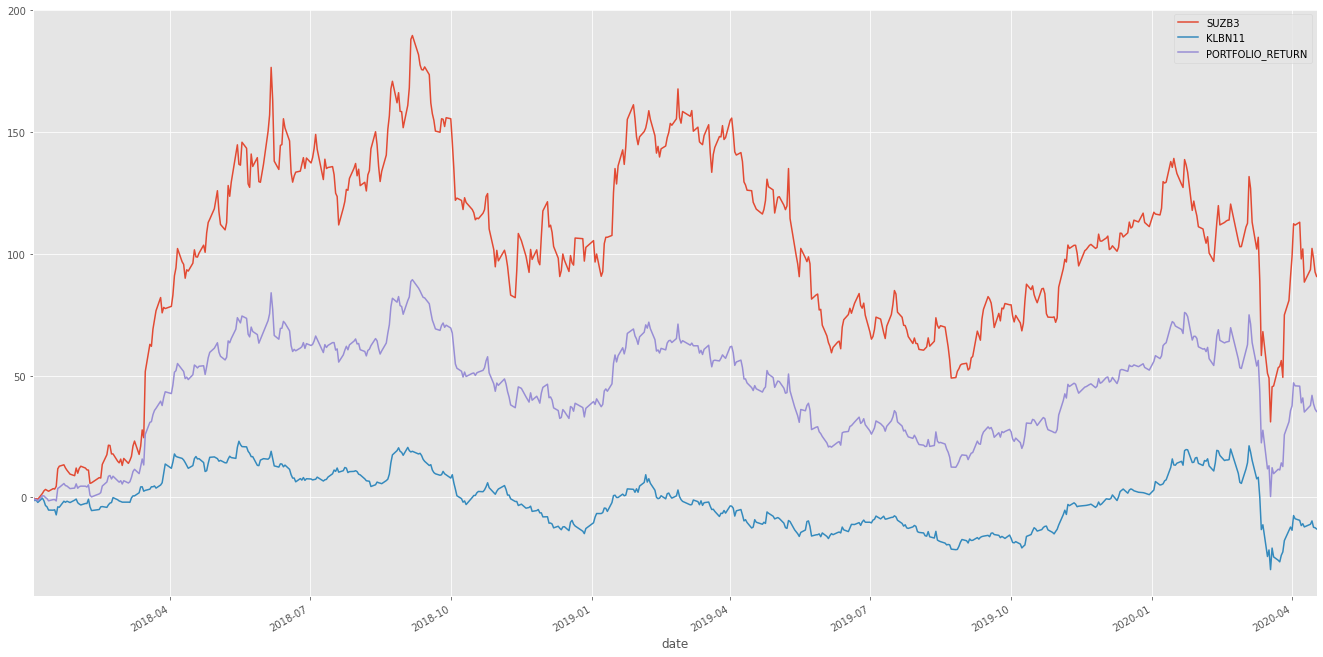

In [20]:
get_portfolio_return(brz, stocks=['SUZB3', 'KLBN11'], start='2018')